In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from pandas import Grouper
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.ar_model import AR

from tqdm import tqdm_notebook
from itertools import product
from typing import Union

from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [4]:
# adjust display settings
%matplotlib inline
plt.rc('figure', figsize=(18, 3))
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.options.display.max_rows = 20

## Load data

In [48]:
# load dataset
dataframe = pd.read_csv('AirPassengers.csv')
dataframe.set_index('Month', inplace=True)

display(dataframe.head())

,#Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


In [6]:
# create a time series
st = pd.Series(dataframe.unstack().values, index=dataframe.index)

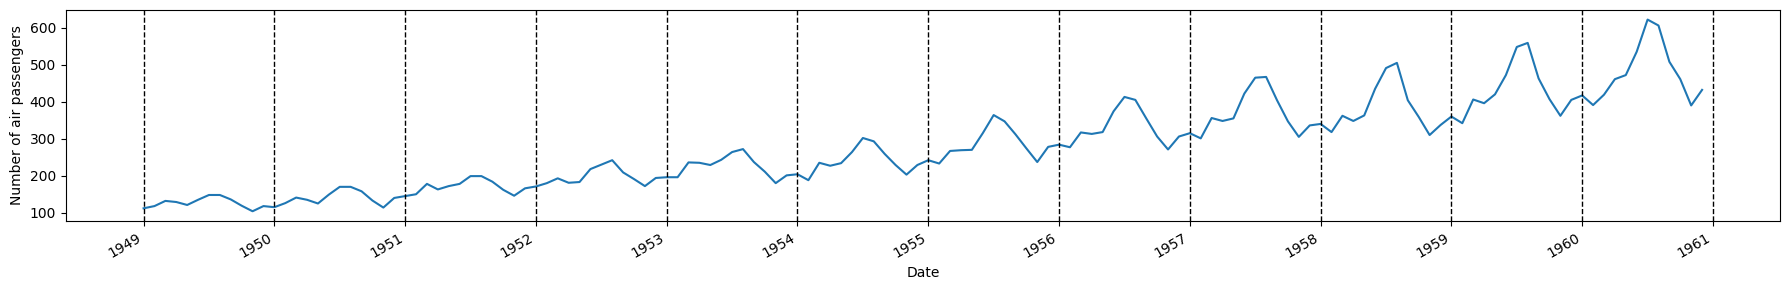

In [7]:
fig, ax = plt.subplots()
# basic plot
st.plot();
for i in np.arange(0, 145, 12):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)
ax.set_xlabel('Date')
ax.set_ylabel('Number of air passengers')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))



fig.autofmt_xdate()
plt.tight_layout()

## identificación de patrones estacionales

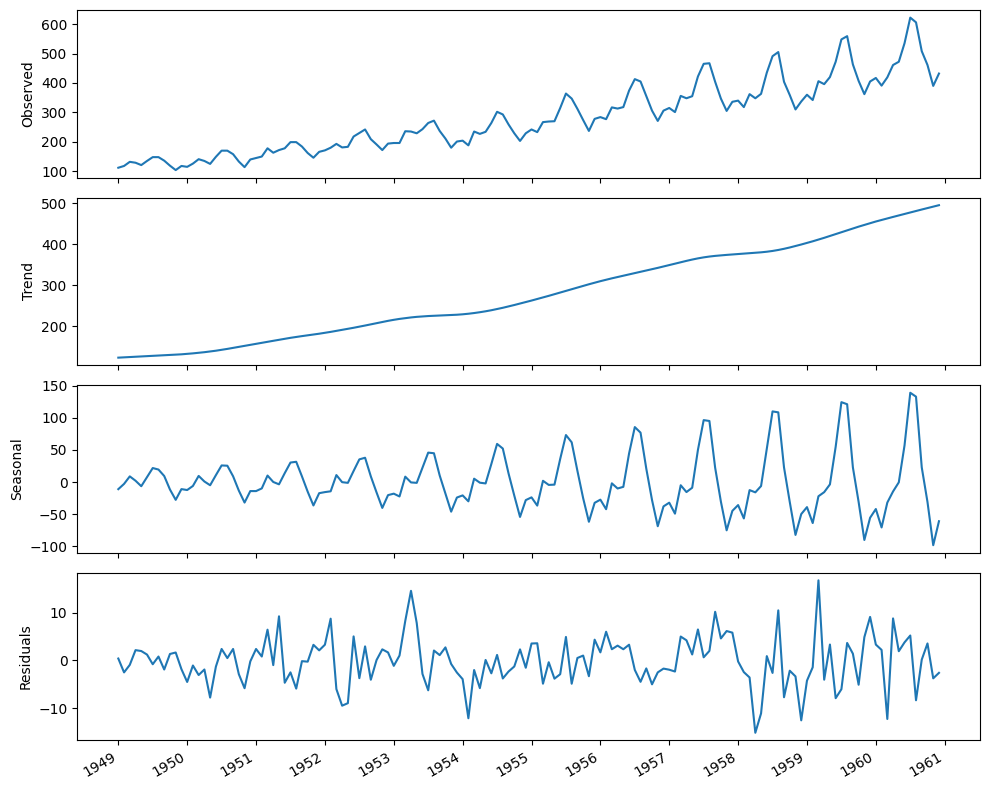

In [8]:
decomposition = STL(dataframe['#Passengers'], period=12).fit()

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(10,8))

ax1.plot(decomposition.observed)
ax1.set_ylabel('Observed')

ax2.plot(decomposition.trend)
ax2.set_ylabel('Trend')

ax3.plot(decomposition.seasonal)
ax3.set_ylabel('Seasonal')

ax4.plot(decomposition.resid)
ax4.set_ylabel('Residuals')

plt.xticks(np.arange(0, 145, 12), np.arange(1949, 1962, 1))

fig.autofmt_xdate()
plt.tight_layout()

## Prueba de estacionariedad


In [9]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, significance_level=0.05):

    """
    Realiza la prueba de Dickey-Fuller Aumentada en una serie de tiempo dada y evalúa su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser probados.
    significance_level (float): El nivel de significancia para la prueba (por defecto es 0.05).

    retorna:
    dict: Un diccionario que contiene el estadístico ADF, el valor p, los valores críticos y si la serie es estacionaria.

    """
    dftest = adfuller(timeseries)
    adf_statistic, p_value, used_lag, nobs, critical_values, icbest = dftest

    # Determinar si la serie es estacionaria basado en el valor p y el estadístico ADF
    is_stationary_p = p_value < significance_level
    is_stationary_adf = adf_statistic < critical_values['5%']  # Utiliza el valor crítico al 5%
    is_stationary = is_stationary_p and is_stationary_adf

    return {
        "ADF Statistic": adf_statistic,
        "p-value": p_value,
        "Critical Values": critical_values,
        "Is Stationary (p-value)": is_stationary_p,
        "Is Stationary (ADF)": is_stationary_adf,
        "Is Stationary (Both)": is_stationary
    }



adf_test_results = test_stationarity(st)
adf_test_results



{'ADF Statistic': 0.8153688792060498,
 'p-value': 0.991880243437641,
 'Critical Values': {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 'Is Stationary (p-value)': False,
 'Is Stationary (ADF)': False,
 'Is Stationary (Both)': False}

### Estacionalización una serie de tiempo
mediante diferenciación recurrente y verifica su estacionariedad.

In [10]:
def make_stationary_recursive(time_series, significance_level=0.05, max_diff=10):
    """
    Estacionaliza una serie de tiempo mediante diferenciación recurrente y
    verifica su estacionariedad.

    Parámetros:
    time_series (array-like): Los datos de la serie de tiempo a ser procesados.
    significance_level (float): El nivel de significancia para la prueba ADF (por defecto es 0.05).
    max_diff (int): El número máximo de diferenciaciones a aplicar.

    Retorna:
    tuple: Una tupla conteniendo el número de diferenciaciones aplicadas (d),
           la serie de tiempo diferenciada y los resultados de la prueba ADF.
    """
    d = 0  # Contador de diferenciaciones
    diff_series = time_series.copy()

    for i in range(max_diff):
        adf_test_results = test_stationarity(diff_series, significance_level)
        if adf_test_results['Is Stationary (Both)']:
            break
        else:
            diff_series = diff_series.diff().dropna()
            d += 1

    return d, diff_series, adf_test_results





In [11]:
d_count, diff_series, adf_results = make_stationary_recursive(st)
d_count, adf_results


(2,
 {'ADF Statistic': -16.384231542468513,
  'p-value': 2.7328918500142026e-29,
  'Critical Values': {'1%': -3.4816817173418295,
   '5%': -2.8840418343195267,
   '10%': -2.578770059171598},
  'Is Stationary (p-value)': True,
  'Is Stationary (ADF)': True,
  'Is Stationary (Both)': True})

## Train-Test Split

In [55]:
# Separando la serie de tiempo diferenciada en conjuntos de entrenamiento y prueba
train_size = int(len(diff_series) * 0.92)
train, test = diff_series[:train_size], diff_series[train_size:]

len(train), len(test)


(130, 12)

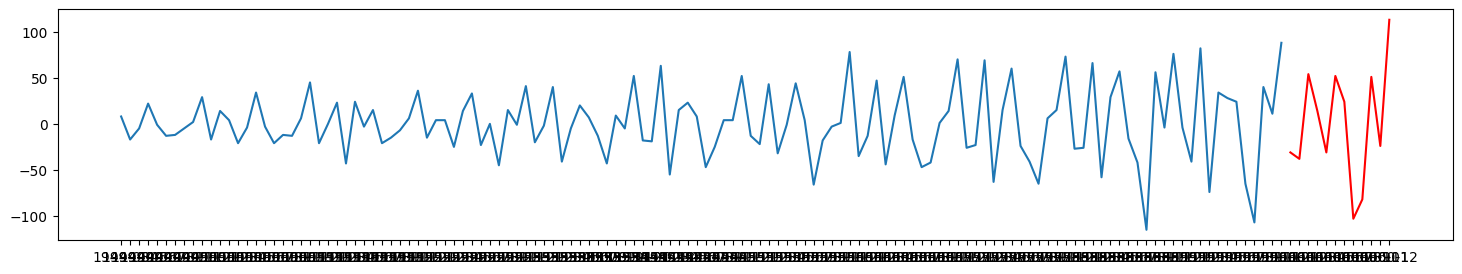

In [56]:
# plot train-test split of time series data
plt.plot(train)
plt.plot(test, color='r');


## Prueba de autocorrelación (ACF) y autocorrelacion parcial (PACF)

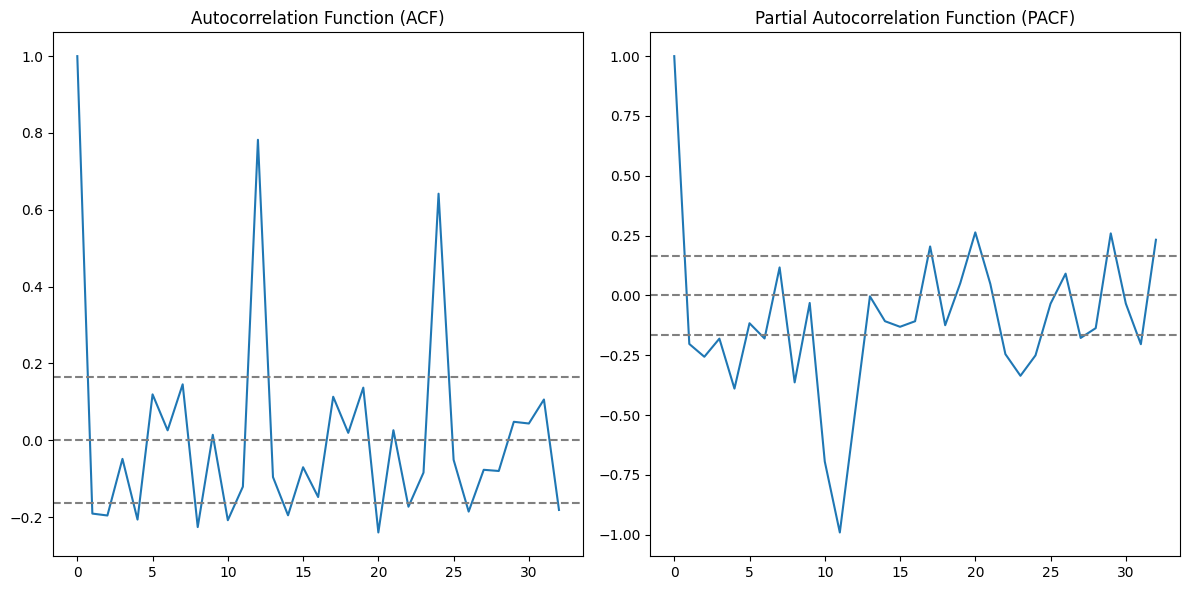

In [57]:
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt

vnlag=min(100, len(train)//4)
lag_acf = acf(diff_series, nlags=vnlag)
lag_pacf = pacf(diff_series, nlags=vnlag, method='ols')

# Plotting ACF
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Autocorrelation Function (ACF)')

# Plotting PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_series)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

plt.show()



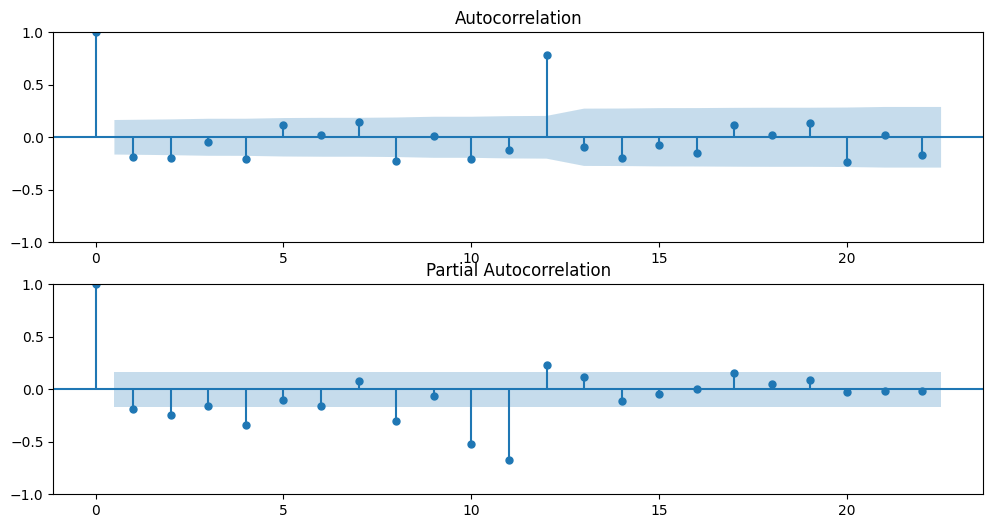

In [58]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.subplots(figsize=(12, 6))
plt.subplot(211)
plot_acf(diff_series, ax=plt.gca())
plt.subplot(212)
plot_pacf(diff_series, ax=plt.gca())
plt.show()

## Modelo ARIMA

In [59]:
from typing import Union
from tqdm import tqdm_notebook
from itertools import product

def optimize_ARIMA(endog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = ARIMA(endog, order=(order[0], d, order[1])).fit()
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df


ps =[1, 2, 4,8,10, 11]
qs=[1,2,4, 12]
d = 0

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train, order_list, d)
print(result_df)

  0%|          | 0/24 [00:00<?, ?it/s]

       (p,q)     AIC
0    (11, 4) 1020.46
1    (11, 1) 1023.74
2    (11, 2) 1024.51
3   (11, 12) 1033.24
4    (10, 4) 1040.89
..       ...     ...
19    (1, 2) 1256.33
20    (2, 2) 1256.99
21    (1, 4) 1258.44
22    (2, 1) 1261.88
23    (1, 1) 1265.86

[24 rows x 2 columns]


In [17]:
def rolling_forecast(df, train_len, horizon: int, window: int, order: list):

    total_len = train_len + horizon
    pred_ARIMA = []
    pred_ARIMA_2 = []

    for i in tqdm_notebook(range(train_len, total_len, window)):
        model = ARIMA(df[:i], order=order)
        res = model.fit()
        predictions = res.forecast(window)
        pred_ARIMA.extend(predictions)

    return pred_ARIMA

In [60]:
# Separando la serie de tiempo diferenciada en conjuntos de entrenamiento y prueba
train_size = int(len(st) * 0.92)
train_st, test_st = st[:train_size], st[train_size:]

len(train_st), len(test_st)


(132, 12)

In [19]:
ps =[1, 2,3, 4,8,10, 11]
qs=[1,2,4, 12]
d = 2

order_list = list(product(ps, qs))

result_df = optimize_ARIMA(train_st, order_list, d)
print(result_df)

  0%|          | 0/28 [00:00<?, ?it/s]

       (p,q)     AIC
0    (11, 4)  995.53
1    (11, 1)  999.39
2    (11, 2) 1000.37
3   (11, 12) 1008.84
4    (10, 4) 1017.11
..       ...     ...
23    (3, 2) 1223.23
24    (1, 4) 1224.04
25    (3, 1) 1228.24
26    (2, 1) 1228.44
27    (1, 1) 1232.59

[28 rows x 2 columns]


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:                ARIMA(11, 2, 4)   Log Likelihood                -493.517
Date:                Tue, 21 Nov 2023   AIC                           1019.035
Time:                        17:10:14   BIC                           1064.915
Sample:                    01-01-1949   HQIC                          1037.678
                         - 12-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8529      0.096     -8.879      0.000      -1.041      -0.665
ar.L2         -0.9694      0.047    -20.689      0.000      -1.061      -0.878
ar.L3         -0.8757      0.087    -10.061      0.0

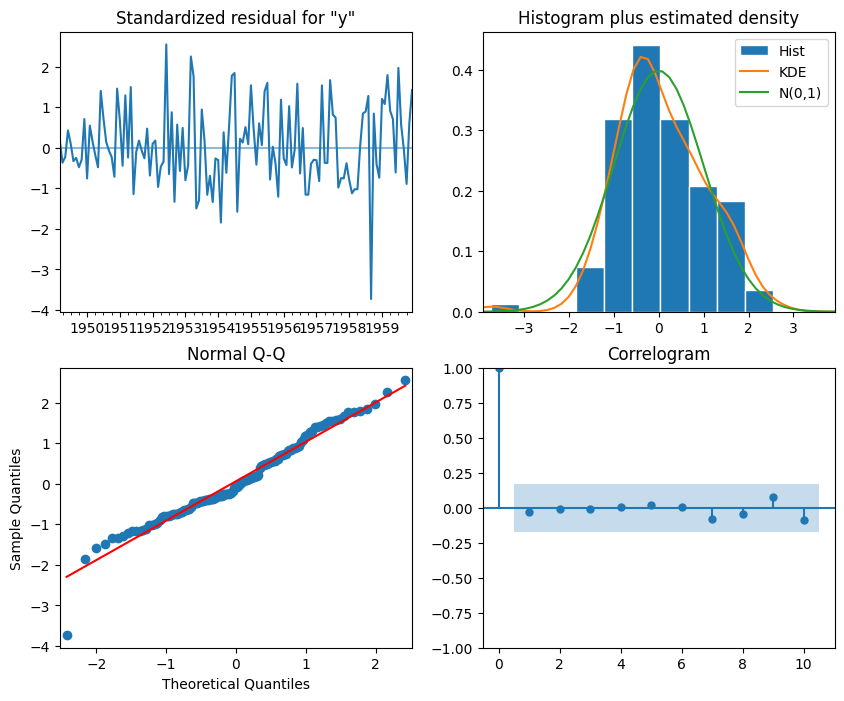

In [61]:
# Ajustando el modelo ARIMA
model = ARIMA(train_st, order=(11, 2, 4))
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,8));

In [63]:
TRAIN_LEN = len(train_st)
HORIZON = len(test_st)
WINDOW = 1
pred_ARIMA_st = rolling_forecast(st, TRAIN_LEN, HORIZON, WINDOW, (2,1,8))
fechas = test_st.index
st_pred_ARIMA_st = pd.Series(pred_ARIMA_st[:len(fechas)], index=fechas)

mse = mean_squared_error(test_st, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse



  0%|          | 0/12 [00:00<?, ?it/s]

(2385.769398722008, 48.84433845106317)

(231139.706652489, 480.7699103027237)

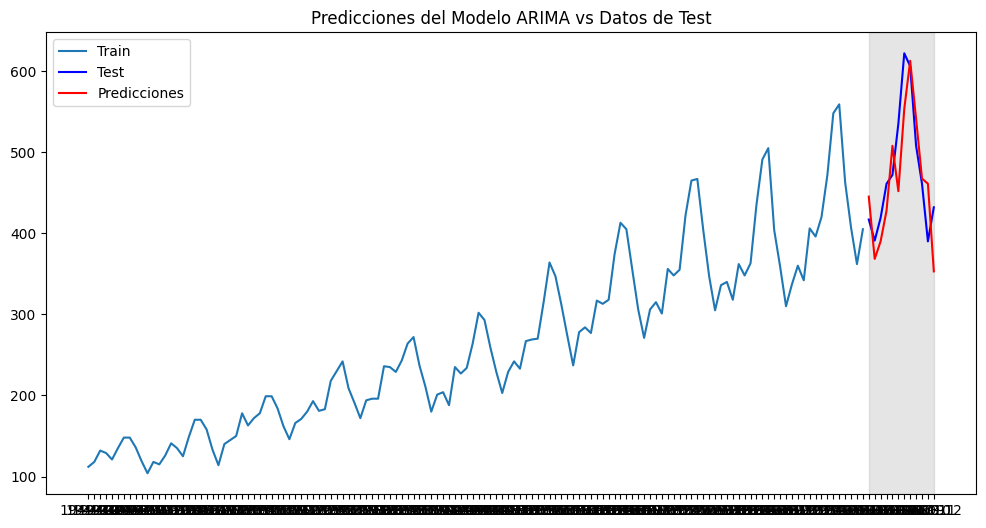

In [64]:
# Visualización de las predicciones y los datos de prueba
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(train_st,label='Train')
ax.plot(test_st, label='Test', color='blue')
ax.plot(st_pred_ARIMA_st, label='Predicciones', color='red')
ax.legend(loc='best')
ax.set_title('Predicciones del Modelo ARIMA vs Datos de Test')


fecha_inicio = test_st.index[0]
fecha_fin = test_st.index[-1]
ax.axvspan(fecha_inicio, fecha_fin, color='#808080', alpha=0.2)


mse = mean_squared_error(test, st_pred_ARIMA_st)
rmse = np.sqrt(mse)

mse, rmse

## Mejor modelo con Validación

In [25]:
def evaluate_arima_model(df, train_len, horizon: int, window: int, order: list):

    test = df[train_len:]
    pred_ARIMA=rolling_forecast(df, train_len, horizon, window, order)
    rmse = np.sqrt(mean_squared_error(test, pred_ARIMA))
    return rmse


def evaluate_models(df, p_values, d_values, q_values):

    train_size = int(len(df) * 0.9)
    train, test = st[:train_size], st[train_size:]

    TRAIN_LEN = len(train)
    HORIZON = len(test)
    WINDOW = 1
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(df, TRAIN_LEN,HORIZON,WINDOW,order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order
                    print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                    continue

    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [ ]:
ps =[1, 2,3, 4,8,10, 11]
qs=[1,2,4, 12]
ds = [1,2]

evaluate_models(st, ps, ds, qs)


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 1, 1) RMSE=50.064


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 1, 2) RMSE=45.231


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 1, 4) RMSE=46.104


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 1, 12) RMSE=36.187


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 2, 1) RMSE=48.390


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 2, 2) RMSE=50.274


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 2, 4) RMSE=50.534


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(1, 2, 12) RMSE=41.466


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 1, 1) RMSE=42.678


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 1, 2) RMSE=40.800


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 1, 4) RMSE=44.622


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 1, 12) RMSE=32.695


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 2, 1) RMSE=47.775


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 2, 2) RMSE=50.194


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 2, 4) RMSE=46.324


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(2, 2, 12) RMSE=42.490


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 1, 1) RMSE=42.885


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 1, 2) RMSE=45.144


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 1, 4) RMSE=45.307


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 1, 12) RMSE=32.335


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 2, 1) RMSE=46.861


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 2, 2) RMSE=50.465


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 2, 4) RMSE=52.416


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(3, 2, 12) RMSE=45.926


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(4, 1, 1) RMSE=47.001


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(4, 1, 2) RMSE=44.583


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(4, 1, 4) RMSE=48.417


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(4, 2, 1) RMSE=45.180


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(4, 2, 2) RMSE=47.193


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(4, 2, 4) RMSE=38.187


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(8, 1, 1) RMSE=43.220


  0%|          | 0/15 [00:00<?, ?it/s]

ARIMA(8, 1, 2) RMSE=41.480


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

optimizar parametros de SARIMA

In [65]:
def optimize_SARIMA(endog: Union[pd.Series, list], order_list: list, d: int, D: int, m: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], m),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df



## Calcular el modelo ARIMA con SARIMA donde P y Q es cero

In [27]:
#Arima con sarima
ps = range(0, 13, 1)
qs = range(0, 13, 1)
Ps = [0]
Qs = [0]

d = 2
D = 0
m = 12

ARIMA2_order_list = list(product(ps, qs, Ps, Qs))
ARIMA2_result_df = optimize_SARIMA(train, ARIMA2_order_list, d, D, m)
ARIMA2_result_df

  0%|          | 0/169 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(10, 5, 0, 0)",32.00
1,"(12, 6, 0, 0)",1049.08
2,"(11, 5, 0, 0)",1051.08
3,"(11, 2, 0, 0)",1055.58
4,"(11, 6, 0, 0)",1059.74
...,...,...
164,"(0, 1, 0, 0)",1372.31
165,"(3, 0, 0, 0)",1374.17
166,"(2, 0, 0, 0)",1381.39
167,"(1, 0, 0, 0)",1435.04


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  127
Model:              SARIMAX(12, 2, 6)   Log Likelihood                -505.540
Date:                Tue, 21 Nov 2023   AIC                           1049.081
Time:                        16:21:59   BIC                           1102.819
Sample:                    03-01-1949   HQIC                          1070.912
                         - 09-01-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7895      0.977     -0.808      0.419      -2.704       1.125
ar.L2         -0.8472      0.848     -0.999      0.318      -2.510       0.815
ar.L3         -0.8115      0.937     -0.866      0.3

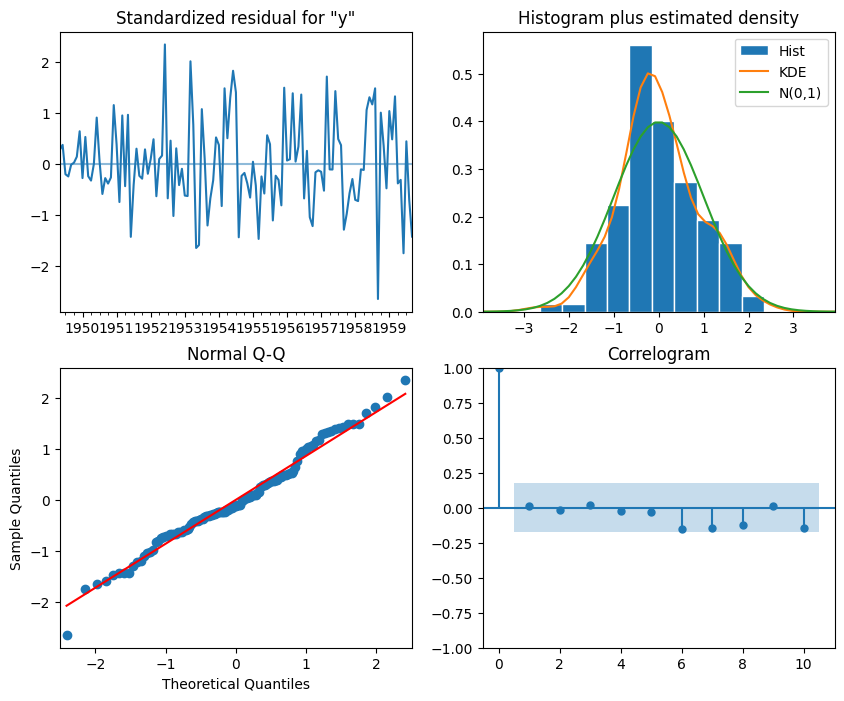

In [35]:
# Ajustando el modelo ARIMA
model = SARIMAX(train, order=(12, 2, 6),simple_differencing=False)
results = model.fit()

print(results.summary())
results.plot_diagnostics(figsize=(10,8));

In [36]:
# sarima
ps = range(0, 4, 1)
qs = range(0, 4, 1)
Ps = range(0, 4, 1)
Qs = range(0, 4, 1)

SARIMA_order_list = list(product(ps, qs, Ps, Qs))

d = 1
D = 1
m = 12

SARIMA_result_df = optimize_SARIMA(train, SARIMA_order_list, d, D, m)
SARIMA_result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q,P,Q)",AIC
0,"(2, 1, 2, 2)",16.00
1,"(2, 3, 1, 2)",879.68
2,"(2, 3, 2, 1)",880.10
3,"(2, 3, 3, 1)",881.80
4,"(2, 3, 3, 3)",882.52
...,...,...
247,"(0, 0, 0, 3)",1108.92
248,"(0, 0, 1, 2)",1108.92
249,"(0, 0, 3, 0)",1109.05
250,"(0, 0, 1, 3)",1109.76


                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  127
Model:             SARIMAX(2, 1, 3)x(2, 1, [1, 2], 12)   Log Likelihood                -435.177
Date:                                 Tue, 21 Nov 2023   AIC                            890.354
Time:                                         16:53:10   BIC                            917.716
Sample:                                     03-01-1949   HQIC                           901.459
                                          - 09-01-1959                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.1641      0.107    -10.910      0.000      -1.373      -0

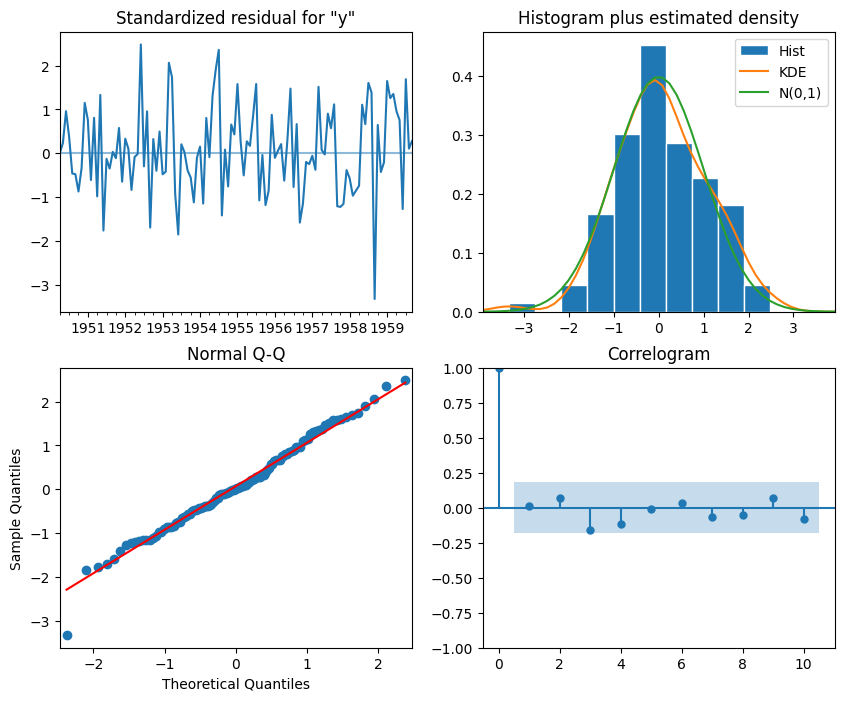

In [39]:
SARIMA_model = SARIMAX(train, order=(2,1,3), seasonal_order=(1,1,2,12))
SARIMA_model_fit = SARIMA_model.fit(disp=False)

print(SARIMA_model_fit.summary())

SARIMA_model_fit.plot_diagnostics(figsize=(10,8));

In [75]:
#obtener predicciones y sus intervalos de confianza para un rango específico de índices de tiempo, ya sea dentro del conjunto de datos de entrenamiento (para validación) o para hacer predicciones fuera de la muestra (futuras).

SARIMA_pred = SARIMA_model_fit.get_prediction(start=132, end=143).predicted_mean

forecast_results = SARIMA_model_fit.forecast(steps=12)

print ()